## Radar verification
#### This notebook shows the code to create the radar data verification plots, using km-resolution building damage data

In [4]:
#load packages
import numpy as np #1.20.3 is default
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from matplotlib import gridspec
import cartopy.crs as ccrs
from climada import CONFIG
sys.path.append(str(CONFIG.local_data.func_dir))
import scClim as sc
from scClim.constants import SUB_CH_EXTENT_2056

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)

#Set the minimum number of buildings per 1km grid cell
min_count=10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#load dataset of damages from building insurances (KGV;Kantonales Gebäudeversicherungen)
# at 1000m resolution
ds_KGV = xr.open_dataset(data_dir+'/KGV/ds_building_dmg_v7_1000m_wModImp.nc')
ds_KGV = ds_KGV.rename({'value':'imp_observed'})
ds_KGV['PAA_MESHS'] = ds_KGV.n_buildings_MESHS/ds_KGV.n_count_exposure
ds_KGV['PAA_crowd'] = ds_KGV.n_buildings_crowd/ds_KGV.n_count_exposure

# add metorological data

In [ ]:
# MESHS
years = np.arange(2002,2021+1)
meshs = xr.open_mfdataset([data_dir+'/V5/MZC/MZC_X1d66_%d.nc'%year for year in years],concat_dim='time', combine='nested', coords='minimal')
meshs = meshs.rename({'time':'date'})
meshs = meshs.sel(chx=slice(SUB_CH_EXTENT_2056[0],SUB_CH_EXTENT_2056[1]),chy=slice(SUB_CH_EXTENT_2056[2],SUB_CH_EXTENT_2056[3]))

#drop dates with no meshs signature
meshs = meshs.MZC.dropna(dim='date',how='all')

#add damage variables (including new dates)
meshs = xr.merge([ds_KGV[['n_count','n_count_exposure','n_dmgs_4km_max','n_exp_4km_max']].drop_vars(['lat','lon']),meshs])
meshs = meshs.rename_vars({'n_count':'n_dmgs','n_count_exposure':'n_exp','MZC':'MESHS'})

meshs.load() #avoid dask error in maximum_filter_nc
#add 4km buffer to MESHS
meshs['MESHS_4km_max']=sc.verification.maximum_filter_nc(meshs.MESHS,radius=4)

#explicit hail drift
meshs['prop_dmg'] = meshs['n_dmgs']/meshs['n_exp']
df_shifts_corr = sc.verification.get_best_shift_per_date(meshs,#.sel(date=slice('2021-06-01','2021-07-30')),
                                    'MESHS','prop_dmg',meshs.n_exp>min_count,range(-5,5+1),range(-5,5+1),
                                    min_n_dmg=1)
meshs_shifted_corr = sc.verification.get_shifted_MESHS(df_shifts_corr,meshs)


In [19]:
#calculate POD per individual claim amd MESHS = 20
POD_p_claim = (meshs.n_dmgs.where(meshs.MESHS>=20).sum()/meshs.n_dmgs.sum()).values
print(f"POD per claim: {POD_p_claim:.2f}")
POD_p_claim_4km = (meshs.n_dmgs.where(meshs.MESHS_4km_max>=20).sum()/meshs.n_dmgs.sum()).values
print(f"POD per claim (4km buffer): {POD_p_claim_4km:.2f}")


POD per claim: 0.89
POD per claim (4km buffer): 0.97


In [ ]:
#MESHS verification dataframe calculation
#MESHS and damage on 1km grid
verif_MESHS = sc.verification.get_at_gridpoints_from_xr(meshs,'MESHS',min_count=min_count)

# MESHS extended to 4km (buffer), dmg on 1km grid
verif_MESHS_4km = sc.verification.get_at_gridpoints_from_xr(meshs,'MESHS_4km_max',min_count=min_count)
df_4km_MESHS, npred_4km = sc.verification.compute_verification_stats(verif_MESHS_4km, haz_var = 'MESHS_4km_max')

# dmg extended with 4km buffer, MESHS on 1km grid
meshs_4km_dmg = meshs[['n_dmgs_4km_max','n_exp_4km_max','MESHS']].rename_vars({'n_dmgs_4km_max':'n_dmgs','n_exp_4km_max':'n_exp'})
verif_MESHS_4km_dmg = sc.verification.get_at_gridpoints_from_xr(meshs_4km_dmg,'MESHS',min_count=min_count)
df_MESHS_4km_dmg, npred_4km_dmg = sc.verification.compute_verification_stats(verif_MESHS_4km_dmg, haz_var = 'MESHS')

#hail drift verification
verif_MESHS_shifted_corr = sc.verification.get_at_gridpoints_from_xr(meshs_shifted_corr,'MESHS',min_count=min_count)
df_MESHS_shifted_corr, npred_shifted_corr = sc.verification.compute_verification_stats(verif_MESHS_shifted_corr, haz_var = 'MESHS')



## Kinetic energy

In [ ]:
#Kintetic energy
years = np.arange(2013,2021+1)
E_kin = xr.open_mfdataset([data_dir+ '/V5/E_kin/CC/E_kin_6t6_%d.nc' % year for year in years] ,concat_dim='time', combine='nested', coords='minimal')
E_kin = E_kin.rename({'time':'date'})#.where(E_kin.E_kin<2000,np.nan)
E_kin = E_kin.sel(chx=slice(SUB_CH_EXTENT_2056[0],SUB_CH_EXTENT_2056[1]),chy=slice(SUB_CH_EXTENT_2056[2],SUB_CH_EXTENT_2056[3]))

# set gridcells to NaN where E_kin is never observed (beam blockage)
E_kin = E_kin.where(E_kin.E_kin.max(dim='date')>0.1,np.nan) #0.1 because at 0dBZ, E_kin is estiamted 0.016

#round to steps of 50 for consistency with calibration
E_kin = E_kin.assign({'E_kin':np.round(E_kin.E_kin/50)*50})

#add damage variables
E_kin = xr.merge([ds_KGV[['n_count','n_count_exposure','n_dmgs_4km_max','n_exp_4km_max']].drop_vars(['lat','lon']),E_kin])
E_kin = E_kin.rename_vars({'n_count':'n_dmgs','n_count_exposure':'n_exp'})

#select only relevant years
E_kin = E_kin.sel(date=slice(f'{years[0]}-01-01',f'{years[-1]}-12-31'))

#add 4km buffer to E_kin
E_kin['E_kin_4km_max']=sc.verification.maximum_filter_nc(E_kin.E_kin,radius=4)

#explicit hail drift
E_kin['prop_dmg'] = E_kin['n_dmgs']/E_kin['n_exp']
df_shifts_corr = sc.verification.get_best_shift_per_date(E_kin,
                                    'E_kin','prop_dmg',E_kin.n_exp>min_count,range(-5,5+1),range(-5,5+1),
                                    min_n_dmg=1)
E_kin_shifted_corr = sc.verification.get_shifted_MESHS(df_shifts_corr,E_kin,'E_kin')



In [ ]:
#E_kin verification dataframe calculation
#E_kin and damage on 1km grid
verif_E_kin = sc.verification.get_at_gridpoints_from_xr(E_kin,'E_kin',min_count=min_count,haz_range=[0,4000])

# E_kin extended to 4km (buffer), dmg on 1km grid
verif_E_kin_4km = sc.verification.get_at_gridpoints_from_xr(E_kin,'E_kin_4km_max',min_count=min_count,haz_range=[0,4000])
df_4km_E_kin, npred_4km = sc.verification.compute_verification_stats(verif_E_kin_4km, haz_var = 'E_kin_4km_max')

# dmg extended with 4km buffer, E_kin on 1km grid
ds_4km_dmg = E_kin[['n_dmgs_4km_max','n_exp_4km_max','E_kin',]].rename_vars({'n_dmgs_4km_max':'n_dmgs','n_exp_4km_max':'n_exp'})
verif_E_kin_4km_dmg = sc.verification.get_at_gridpoints_from_xr(ds_4km_dmg,'E_kin',min_count=min_count,haz_range=[0,4000])
df_E_kin_4km_dmg, _ = sc.verification.compute_verification_stats(verif_E_kin_4km_dmg, haz_var = 'E_kin')


#hail drift verification
verif_E_kin_shifted_corr = sc.verification.get_at_gridpoints_from_xr(E_kin_shifted_corr,'E_kin',min_count=min_count,haz_range=[0,4000])
df_E_kin_shifted_corr, npred_shifted_corr = sc.verification.compute_verification_stats(verif_E_kin_shifted_corr, haz_var = 'E_kin')


## Maximum reflectivity (dBZ)

In [ ]:
#dBZ
years = np.arange(2013,2021+1)
dBZ = xr.open_mfdataset([data_dir+ '/V5/CZC/CZC_6t6_%d.nc' % year for year in years] ,concat_dim='time', combine='nested', coords='minimal')
dBZ = dBZ.rename({'time':'date'})
dBZ = dBZ.sel(chx=slice(SUB_CH_EXTENT_2056[0],SUB_CH_EXTENT_2056[1]),chy=slice(SUB_CH_EXTENT_2056[2],SUB_CH_EXTENT_2056[3]))

#select only values larger than 45 and drop empty dates
dBZ = dBZ.where(dBZ.CZC>40,np.nan) #INT_RANGE_DICT['dBZ'][0]=45, but 40 gives better visualisation
dBZ = dBZ.CZC.dropna(dim='date',how='all')

#add damage variables
dBZ = xr.merge([ds_KGV[['n_count','n_count_exposure','n_dmgs_4km_max','n_exp_4km_max']].drop_vars(['lat','lon']),dBZ])
dBZ = dBZ.rename_vars({'n_count':'n_dmgs','n_count_exposure':'n_exp','CZC':'dBZ'})

#select only relevant years
dBZ = dBZ.sel(date=slice(f'{years[0]}-01-01',f'{years[-1]}-12-31'))

dBZ.load() #avoid dask error in maximum_filter_nc
#add 4km buffer to dBZ
dBZ['dBZ_4km_max']=sc.verification.maximum_filter_nc(dBZ.dBZ,radius=4)

#explicit hail drift
dBZ['prop_dmg'] = dBZ['n_dmgs']/dBZ['n_exp']
df_shifts_corr = sc.verification.get_best_shift_per_date(dBZ,
                                    'dBZ','prop_dmg',dBZ.n_exp>min_count,range(-5,5+1),range(-5,5+1),
                                    min_n_dmg=1)
dBZ_shifted_corr = sc.verification.get_shifted_MESHS(df_shifts_corr,dBZ,'dBZ')


In [ ]:
#dBZ verification dataframe calculation
#dBZ and damage on 1km grid
verif_dBZ = sc.verification.get_at_gridpoints_from_xr(dBZ,'dBZ',min_count=min_count,haz_range=[40,70])

# dBZ extended to 4km (buffer), dmg on 1km grid
verif_dBZ_4km = sc.verification.get_at_gridpoints_from_xr(dBZ,'dBZ_4km_max',min_count=min_count,haz_range=[40,70])
df_4km_dBZ, npred_4km = sc.verification.compute_verification_stats(verif_dBZ_4km, haz_var = 'dBZ_4km_max')

# dmg extended with 4km buffer, dBZ on 1km grid
ds_4km_dmg = dBZ[['n_dmgs_4km_max','n_exp_4km_max','dBZ',]].rename_vars({'n_dmgs_4km_max':'n_dmgs','n_exp_4km_max':'n_exp'})
verif_dBZ_4km_dmg = sc.verification.get_at_gridpoints_from_xr(ds_4km_dmg,'dBZ',min_count=min_count,haz_range=[40,70])
df_dBZ_4km_dmg, _ = sc.verification.compute_verification_stats(verif_dBZ_4km_dmg, haz_var = 'dBZ')

# hail drift verification
verif_dBZ_shifted_corr = sc.verification.get_at_gridpoints_from_xr(dBZ_shifted_corr,'dBZ',min_count=min_count,haz_range=[40,70])
df_dBZ_shifted_corr, _ = sc.verification.compute_verification_stats(verif_dBZ_shifted_corr, haz_var = 'dBZ')

## Vertically integrated liquid (VIL)

In [ ]:
#VIL
years = np.arange(2013,2021+1)
VIL = xr.open_mfdataset([data_dir+ '/V5/VIL/dLZC_6t6_%d.nc' % year for year in years] ,concat_dim='time', combine='nested', coords='minimal')
VIL = VIL.rename({'time':'date'})
VIL = VIL.sel(chx=slice(SUB_CH_EXTENT_2056[0],SUB_CH_EXTENT_2056[1]),chy=slice(SUB_CH_EXTENT_2056[2],SUB_CH_EXTENT_2056[3]))

# #add damage variables
VIL = xr.merge([ds_KGV[['n_count','n_count_exposure','n_dmgs_4km_max','n_exp_4km_max']].drop_vars(['lat','lon']),VIL])
VIL = VIL.rename_vars({'n_count':'n_dmgs','n_count_exposure':'n_exp','dLZC':'VIL'})

# #select only relevant years
VIL = VIL.sel(date=slice(f'{years[0]}-01-01',f'{years[-1]}-12-31'))

VIL.load() #avoid dask error in maximum_filter_nc
# #add 4km buffer to VIL
VIL['VIL_4km_max']=sc.verification.maximum_filter_nc(VIL.VIL,radius=4)


In [ ]:
#VIL
# VIL verification dataframe calculation
verif_VIL = sc.verification.get_at_gridpoints_from_xr(VIL,'VIL',min_count=min_count)

# VIL extended to 4km (buffer), dmg on 1km grid
verif_VIL_4km = sc.verification.get_at_gridpoints_from_xr(VIL,'VIL_4km_max',min_count=min_count)
df_4km_VIL, npred_4km = sc.verification.compute_verification_stats(verif_VIL_4km, haz_var = 'VIL_4km_max')

# dmg extended with 4km buffer, VIL on 1km grid
vil_4km_dmg = VIL[['n_dmgs_4km_max','n_exp_4km_max','VIL']].rename_vars({'n_dmgs_4km_max':'n_dmgs','n_exp_4km_max':'n_exp'})
verif_VIL_4km_dmg = sc.verification.get_at_gridpoints_from_xr(vil_4km_dmg,'VIL',min_count=min_count)
df_VIL_4km_dmg, npred_4km = sc.verification.compute_verification_stats(verif_VIL_4km_dmg, haz_var = 'VIL')

## Plot results

In [58]:
def plot_verification(at_centroid_data,df_hazExtend,df_dmgExtend,haz_var = 'MESHS',
                    min_count=None,sec_plot_type='buffer',max_x=None,ax=None,
                    plot_bins=True,plot_n_cells = True,
                    plot_ratio=True,plot_title=True,legend_anchor=(0.5, -0.25),
                    lw1=4,lw2=2):

    if sec_plot_type == 'buffer':
        lbl = '4km buffer'
    elif sec_plot_type == 'shifted':
        pd.testing.assert_frame_equal(df_hazExtend,df_dmgExtend)
        lbl = 'with hail drift'

    if ax is None:
        fig,ax=plt.subplots(figsize=(6,4))
    else:
        fig = ax.get_figure()
    df, npred = sc.verification.compute_verification_stats(at_centroid_data, haz_var = haz_var)

    if max_x is None:
        x=df.index[:]#[1:]
        x_haz = df_hazExtend.index[:]
        x_dmg = df_dmgExtend.index[:]
    else:
        imax = np.where(df.index == max_x)[0][0]
        x=df.index[0:imax]
        x_haz = df_hazExtend.index[0:np.where(df_hazExtend.index == max_x)[0][0]]
        x_dmg = df_dmgExtend.index[0:np.where(df_dmgExtend.index == max_x)[0][0]]

    h2=ax.plot(x,df.POD[x],color='blue',linewidth=lw1, linestyle = 'solid', label = 'POD')
    ax.plot(x_haz,df_hazExtend.POD[x_haz],color='blue',linewidth=lw2, linestyle = 'dashed', label = f'POD\n({lbl})',alpha=0.5)
    h1=ax.plot(x,df.FAR[x],color='r',linewidth=lw1, label = 'FAR')
    ax.plot(x_dmg,df_dmgExtend.FAR[x_dmg],color='r',linewidth=lw2, label = f'FAR\n({lbl})',linestyle = 'dashed',alpha=0.5)


    h2=ax.plot(x,df.HSS[x],color='k',linewidth=lw1, linestyle = 'solid', label = 'HSS')
    if sec_plot_type == 'shifted':
        ax.plot(x,df_hazExtend.HSS[x],color='k',linewidth=lw2, linestyle = 'dashed', label = f'HSS\n({lbl})',alpha=0.5)

    if plot_title:
        ax.set_title(f'Haz: {haz_var}, only gridcells with >{min_count} buildings')
    # ax.tick_params(axis='both', labelsize=17)

    if plot_ratio and sec_plot_type == 'buffer':
        ax.plot(x,df.PRED[x]/npred,color='grey',linestyle='dotted',linewidth=lw1, label='Ratio of\ntotal predictions')

    if plot_n_cells:
        ax.text(0.97,0.97,'n = {}'.format(npred),horizontalalignment='right',zorder=3,
            verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='dimgrey', alpha=0.5))

    #ax2.plot(x,df.OBS[x],color='dimgrey',linestyle='dashed',linewidth=2, label='Number of hail occurences')
    ax.set(yticks=np.arange(0,1.1,0.2),xlim=(x[0],x[-1]),ylim=(0,1))
    ax.set_xlabel(sc.constants.INT_LABEL_DICT[haz_var].replace('Intensity: ',''))
    ax.legend(loc='upper center',bbox_to_anchor=legend_anchor,ncol=3) #(x,y, width, height)
    #ax.legend(ncol=2,loc='upper left')
    ax.grid(linestyle='dotted')

    if plot_bins:
        dmg_bin_size=sc.constants.DMG_BIN_DICT[haz_var]
        #create dataframe with number of gridcells in each bin (not number of exposure points!)
        df_n_cells = at_centroid_data.loc[at_centroid_data.n_exp>min_count,:].groupby(haz_var).count()
        #select only relevant range (same as in verification dataframe)
        df_n_cells = df_n_cells.loc[x,:]
        df_n_cells = df_n_cells.rename(columns={'n_exp':'count_cells'})
        sc.E.plot_dmg_bin(df_n_cells,ax,pl_var='count_cells',color='grey',bin_size=dmg_bin_size)

    return fig, ax, df

C:\Users/timschmi/Documents/PhD/code/scClim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
C:\Users/timschmi/Documents/PhD/code/scClim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))


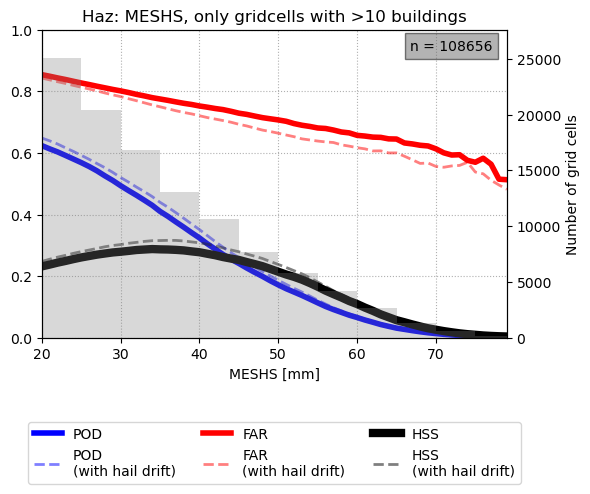

In [50]:
max_x = 80
fig, ax, _ =plot_verification(verif_MESHS,df_MESHS_shifted_corr,df_MESHS_shifted_corr,'MESHS',min_count,'shifted',max_x=max_x)

## combined figure

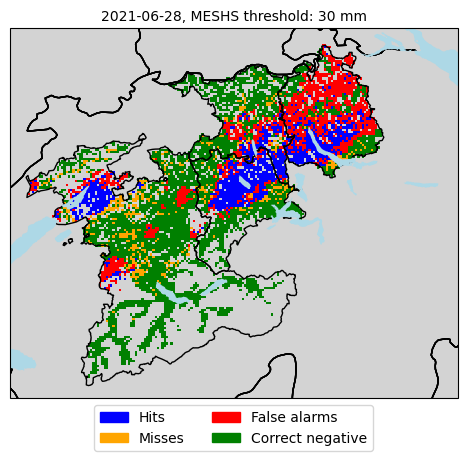

In [55]:
#plot map example
def plot_verif_map(ds_haz,haz_str,date,haz_tresh,min_exp=0,legend=True,ax=None,
                   title_size=None,leg_bbox=None,title=None):
    if leg_bbox is None:
        leg_bbox = (0.5, 0)
    ds_haz_sel = ds_haz.sel(date=date)
    if haz_str == 'MESHS': #fill nan MESHS values with 0
        ds_haz_sel[haz_str] = ds_haz_sel[haz_str].fillna(0)
    if ax is None:
        ax = sc.plot_nc((ds_haz_sel[haz_str]>haz_tresh)&(ds_haz_sel.n_exp>0)&(ds_haz_sel.n_dmgs==0),
                        crs='EPSG:2056',cmap='red',pl_type='bool_field') # false positives
    else:
        sc.plot_nc((ds_haz_sel[haz_str]>haz_tresh)&(ds_haz_sel.n_exp>0)&(ds_haz_sel.n_dmgs==0),
                   crs='EPSG:2056',cmap='red',pl_type='bool_field',ax=ax) # false positives
    sc.plot_nc((ds_haz_sel.n_dmgs>0)&(ds_haz_sel[haz_str]>haz_tresh),
               crs='EPSG:2056',cmap='blue',pl_type='bool_field',ax=ax) # true positive
    sc.plot_nc((ds_haz_sel.n_dmgs>0)&(ds_haz_sel[haz_str]<=haz_tresh),
               crs='EPSG:2056',cmap='orange',pl_type='bool_field',ax=ax) # missed events (false negative)
    sc.plot_nc((ds_haz_sel.n_dmgs==0)&(ds_haz_sel[haz_str]<=haz_tresh),
               crs='EPSG:2056',cmap='green',pl_type='bool_field',ax=ax) # correct rejection
    sc.plot_nc((ds_haz_sel.n_exp.fillna(0)<=min_exp),crs='EPSG:2056',
               cmap='lightgrey',pl_type='bool_field',ax=ax) #non considered gridcells

    sc.plot_canton(ax=ax,canton=['Bern','Luzern','Aargau','Zürich'],zorder=2)
    int_label = sc.constants.INT_LABEL_DICT[haz_str]
    if title is None:
        title = f"{date}, {int_label[:int_label.find('[')].replace('Intensity: ','')}threshold: {haz_tresh} {sc.constants.UNIT_DICT[haz_str]}"
    elif title == 'no_date':
        title = f"{int_label[:int_label.find('[')].replace('Intensity: ','')}threshold: {haz_tresh} {sc.constants.UNIT_DICT[haz_str]}"
    ax.set_title(title,fontsize=title_size)
    if legend:
        blue = mpatches.Patch(color='blue', label='Hits')
        red = mpatches.Patch(color='red', label='False alarms')
        orange = mpatches.Patch(color='orange', label='Misses')
        green = mpatches.Patch(color='green', label='Correct negative')
        legend = ax.legend(handles=[blue,orange,red,green],loc='upper center',
                           bbox_to_anchor=leg_bbox,ncol=2)

date = '2021-06-28'
haz_tresh = 30
plot_verif_map(meshs,'MESHS',date,haz_tresh,min_exp=10)

C:\Users/timschmi/Documents/PhD/code/scClim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
C:\Users/timschmi/Documents/PhD/code/scClim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
C:\Users/timschmi/Documents/PhD/code/scClim\scClim\verification.py:133: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
C:\Users/timschmi/Documents/PhD/code/scClim\scClim\verification.py:133: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(POFD)-np.log(POD)+np.log(1-POD)-np.log(1-POFD))/(np.log(POFD)+np.log(POD)+np.log(1-POD)+np.log(1-POFD))
C:\Users/timschmi/Documents/PhD/

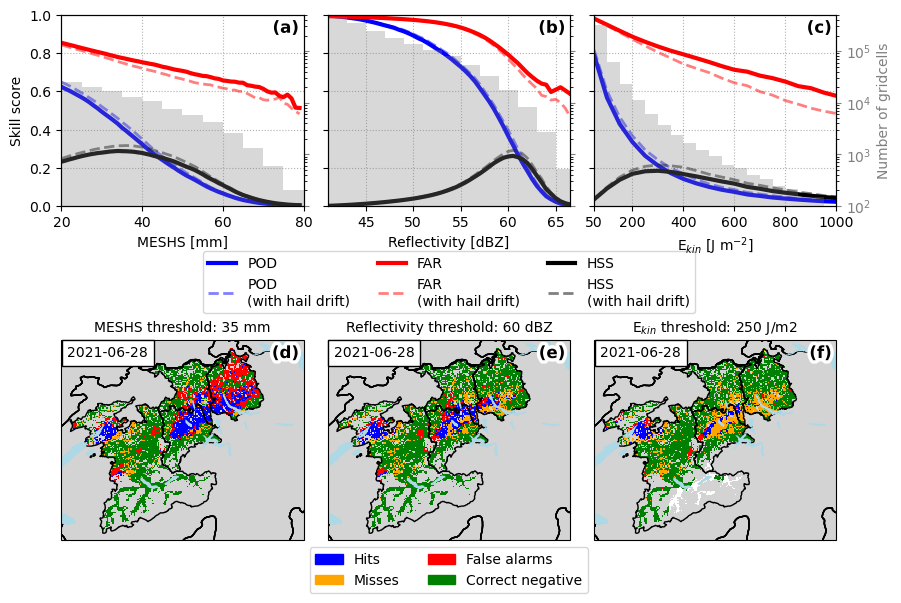

In [62]:
#combined figure
fontsize = 10
fig = plt.figure(figsize=(10,8))

gs0 = gridspec.GridSpec(2,1, figure=fig,height_ratios=[1,2],hspace=0.15)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0],wspace=0.1)

ax1 = fig.add_subplot(gs00[0])
ax2 = fig.add_subplot(gs00[1])
ax3 = fig.add_subplot(gs00[2])

# the following syntax does the same as the GridSpecFromSubplotSpec call above:
gs01 = gs0[1].subgridspec(1, 3, wspace=0.1)

ax21 = fig.add_subplot(gs01[0],projection=ccrs.epsg(2056))
ax22 = fig.add_subplot(gs01[1],projection=ccrs.epsg(2056))
ax23 = fig.add_subplot(gs01[2],projection=ccrs.epsg(2056))

axes = [ax1,ax2,ax3]
axes2= [ax21,ax22,ax23]

verif_args = {'plot_n_cells':False,'plot_ratio':False,'plot_title':False,'lw1':3,'lw2':2}

fig1, __, _ = plot_verification(verif_MESHS,df_MESHS_shifted_corr,df_MESHS_shifted_corr,
                                'MESHS',min_count,'shifted',max_x=80,
                                 ax=axes[0],**verif_args)
ax1.get_legend().remove()
ax1.set(xticks=[20,40,60,80])
fig2, __, _ = plot_verification(verif_dBZ,df_dBZ_shifted_corr,df_dBZ_shifted_corr,
                                'dBZ', min_count,'shifted',max_x=67,
                                ax=axes[1],**verif_args,legend_anchor=(0.5, -0.2))
ax2.set(xticks=[45,50,55,60,65])
fig3, __, _ = plot_verification(verif_E_kin,df_E_kin_shifted_corr,df_E_kin_shifted_corr,
                                'E_kin',min_count,'shifted',max_x=1050,
                                 ax=axes[2],**verif_args)
ax3.set(xticks=[50,200,400,600,800,1000])
ax3.get_legend().remove()
for ax in axes[1:]:
    ax.set(ylabel=None,yticklabels=[])
#edit scale for right axes (Number of gridcells)
for i,ax in enumerate(fig.get_axes()[-3:]): #fig.get_axes()[3:]
    ax.set(ylim=(100,500000),yscale='log')
    ax.tick_params(axis='y',color='grey',labelcolor='grey',labelsize=fontsize)

    if not i==2:
        ax.set(ylabel=None,yticklabels=[])
    else:
        ax.set_ylabel('Number of gridcells',color='grey',fontsize=fontsize)
#adjust all axes:
for ax in axes:
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    # ax.set(labelsize=fontsize)

ax1.set(ylabel='Skill score')#'POD, FAR, HSS')


#Plot examples
ds_haz_arr = [meshs,dBZ,E_kin]
haz_str_arr = ['MESHS','dBZ','E_kin']
haz_threshs = [35,60,250]
date = '2021-06-28'

n_plots = len(ds_haz_arr)
legend_loc = np.floor(n_plots/2)
leg_bbox = (0.5,0.0)

for i,(ds_haz,haz_str,haz_thresh,ax) in enumerate(zip(ds_haz_arr,haz_str_arr,
                                                      haz_threshs,axes2)):
    legend = True if i==legend_loc else False
    plot_verif_map(ds_haz,haz_str,date,haz_thresh,min_exp=min_count,ax=ax,
                   legend=legend,title_size=10,leg_bbox=leg_bbox,title='no_date')
    ax.annotate(date,xy=(0.025,0.97),xycoords='axes fraction',ha='left',
                va='top',bbox={'fc':'white'})

# add labels for all six axes:
for ax,lbl in zip(np.concatenate((axes,axes2)),['a','b','c','d','e','f']):
    txt = ax.text(0.98,0.97,f"({lbl})", transform=ax.transAxes,ha='right',
                  va='top',fontsize=12,weight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])


fig.savefig(f'{out_dir}/paper1/fig04.png',dpi=300,bbox_inches='tight')